In [ ]:
import sys
import os
import math
import json
import warnings
warnings.filterwarnings('ignore')


In [ ]:
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False


In [ ]:
if IN_COLAB:
    !pip -q install xgboost shap tensorflow==2.12.0 joblib

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(8,5)})

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib

In [ ]:
# for ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# SHAP
import shap

RND = 42
np.random.seed(RND)
tf.random.set_seed(RND)

In [ ]:
# Utility plotting helper
def print_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"R2 = {r2:.4f} | MAE = {mae:.3f} | RMSE = {rmse:.3f}")
    return {'r2':r2,'mae':mae,'rmse':rmse}

In [ ]:
DATA_PATH = r"C:\Users\Ishu\Downloads\Tempering data for carbon and low alloy steels - Raiipa.csv"

if IN_COLAB:
    from google.colab import files
    print("Please upload the CSV file now (select file in dialog)...")
    uploaded = files.upload()
    uploaded_fname = list(uploaded.keys())[0]
    DATA_PATH = uploaded_fname
    print("Uploaded", uploaded_fname)

# Load CSV
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded:", DATA_PATH)
print("Rows,Cols:", df.shape)
df.head().T

Please upload the CSV file now (select file in dialog)...


Saving Tempering data for carbon and low alloy steels - Raiipa.csv to Tempering data for carbon and low alloy steels - Raiipa.csv
Uploaded Tempering data for carbon and low alloy steels - Raiipa.csv
Loaded: Tempering data for carbon and low alloy steels - Raiipa.csv
Rows,Cols: (1466, 17)


,0,1,2,3,4
Source,"Grange and Baughman, 1956","Grange and Baughman, 1956","Grange and Baughman, 1956","Grange and Baughman, 1956","Grange and Baughman, 1956"
Steel type,AISI-SAE 1026,AISI-SAE 1026,AISI-SAE 1026,AISI-SAE 1026,AISI-SAE 1026
Initial hardness (HRC) - post quenching,?,?,?,?,?
Tempering time (s),600,600,600,600,600
Tempering temperature (ºC),204.4,260.0,315.6,371.1,426.7
C (%wt),0.25,0.25,0.25,0.25,0.25
Mn (%wt),0.79,0.79,0.79,0.79,0.79
P (%wt),0.012,0.012,0.012,0.012,0.012
S (%wt),0.026,0.026,0.026,0.026,0.026
Si (%wt),0.11,0.11,0.11,0.11,0.11


In [ ]:
# quick copy
data = df.copy()

# Normalize column names (strip and lower)
data.columns = [c.strip() for c in data.columns]

# Inspect columns to pick relevant names
print("Columns:\n", data.columns.tolist())

# Replace '?' and empty strings with NaN
data.replace('?', np.nan, inplace=True)
data.replace('', np.nan, inplace=True)

# Attempt to coerce numeric columns
# Common column names from your file (as seen earlier)
possible_numeric_cols = [
    'Initial hardness (HRC) - post quenching',
    'Tempering time (s)', 'Tempering temperature (ºC)',
    'C (%wt)', 'Mn (%wt)', 'P (%wt)', 'S (%wt)', 'Si (%wt)',
    'Ni (%wt)', 'Cr (%wt)', 'Mo (%wt)', 'V (%wt)', 'Al (%wt)', 'Cu (%wt)',
    'Final hardness (HRC) - post tempering'
]

for c in possible_numeric_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors='coerce')

# Drop rows missing final hardness
target_col = 'Final hardness (HRC) - post tempering'
if target_col not in data.columns:
    raise RuntimeError(f"Target column '{target_col}' not found. Check CSV headers.")
data = data.dropna(subset=[target_col])

# Fill or drop rows with missing key features; for now drop rows with missing composition or tempering temp/time
essential_cols = ['C (%wt)','Mn (%wt)','Si (%wt)','Tempering temperature (ºC)','Tempering time (s)']
existing_essential = [c for c in essential_cols if c in data.columns]
print("Essential (found):", existing_essential)
data = data.dropna(subset=existing_essential)

# Create derived features
# Carbon Equivalent (popular definition - adjust if you prefer another)
def carbon_equivalent(row):
    C = row.get('C (%wt)', 0.0) or 0.0
    Mn = row.get('Mn (%wt)', 0.0) or 0.0
    Cr = row.get('Cr (%wt)', 0.0) or 0.0
    Mo = row.get('Mo (%wt)', 0.0) or 0.0
    V = row.get('V (%wt)', 0.0) or 0.0
    Ni = row.get('Ni (%wt)', 0.0) or 0.0
    Cu = row.get('Cu (%wt)', 0.0) or 0.0
    return C + Mn/6 + (Cr + Mo + V)/5 + (Ni + Cu)/15

data['CE'] = data.apply(carbon_equivalent, axis=1)

# Normalize tempering time into minutes if given in seconds
if 'Tempering time (s)' in data.columns:
    data['Tempering_time_min'] = data['Tempering time (s)'] / 60.0
else:
    data['Tempering_time_min'] = data.get('Tempering time (min)', np.nan)

# Build feature list (only include columns that exist)
candidate_features = [
    'C (%wt)','Mn (%wt)','Si (%wt)','Cr (%wt)','Ni (%wt)','Mo (%wt)','V (%wt)',
    'Tempering temperature (ºC)','Tempering_time_min','Initial hardness (HRC) - post quenching','CE'
]
features = [c for c in candidate_features if c in data.columns]
print("Features used:", features)


Columns:
 ['Source', 'Steel type', 'Initial hardness (HRC) - post quenching', 'Tempering time (s)', 'Tempering temperature (ºC)', 'C (%wt)', 'Mn (%wt)', 'P (%wt)', 'S (%wt)', 'Si (%wt)', 'Ni (%wt)', 'Cr (%wt)', 'Mo (%wt)', 'V (%wt)', 'Al (%wt)', 'Cu (%wt)', 'Final hardness (HRC) - post tempering']
Essential (found): ['C (%wt)', 'Mn (%wt)', 'Si (%wt)', 'Tempering temperature (ºC)', 'Tempering time (s)']
Features used: ['C (%wt)', 'Mn (%wt)', 'Si (%wt)', 'Cr (%wt)', 'Ni (%wt)', 'Mo (%wt)', 'V (%wt)', 'Tempering temperature (ºC)', 'Tempering_time_min', 'Initial hardness (HRC) - post quenching', 'CE']


In [ ]:
# ✅ Step 1: Define input features (X) and target (y)
X = df.drop(['Final hardness (HRC) - post tempering'], axis=1)
y = df['Final hardness (HRC) - post tempering']

# ✅ Step 2: Ensure X is always a DataFrame
if isinstance(X, np.ndarray):  # If already converted earlier
    X = pd.DataFrame(X, columns=feature_cols)

# ✅ Step 3: Save feature names
feature_cols = X.columns

# ✅ Step 4: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 5: Ensure X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train, columns=feature_cols)
X_test = pd.DataFrame(X_test, columns=feature_cols)


In [ ]:
# Final target
target = target_col

# Drop rows with any remaining NaNs in features
data = data.dropna(subset=features + [target])
data.reset_index(drop=True, inplace=True)
print("After cleaning rows,cols:", data.shape)

# Quick stats
display(data[features + [target]].describe().T)


After cleaning rows,cols: (517, 19)


,count,mean,std,min,25%,50%,75%,max
C (%wt),517.0,0.687660,0.270988,0.310000,0.410000,0.620,0.980000,1.150000
Mn (%wt),517.0,0.627524,0.182611,0.300000,0.520000,0.580,0.810000,0.880000
Si (%wt),517.0,0.195996,0.075857,0.060000,0.100000,0.220,0.260000,0.300000
Cr (%wt),517.0,0.485716,0.517754,0.010000,0.010000,0.030,0.980000,1.420000
Ni (%wt),517.0,0.171644,0.519346,0.000000,0.000000,0.000,0.000000,1.740000
Mo (%wt),517.0,0.043946,0.093700,0.000000,0.000000,0.000,0.000000,0.260000
V (%wt),517.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
Tempering temperature (ºC),517.0,358.588008,195.665577,100.000000,200.000000,300.000,500.000000,700.000000
Tempering_time_min,517.0,308.257253,550.622386,0.166667,1.500000,15.000,150.000000,1440.000000
Initial hardness (HRC) - post quenching,517.0,61.493617,5.656383,46.500000,58.800000,63.100,66.500000,67.000000


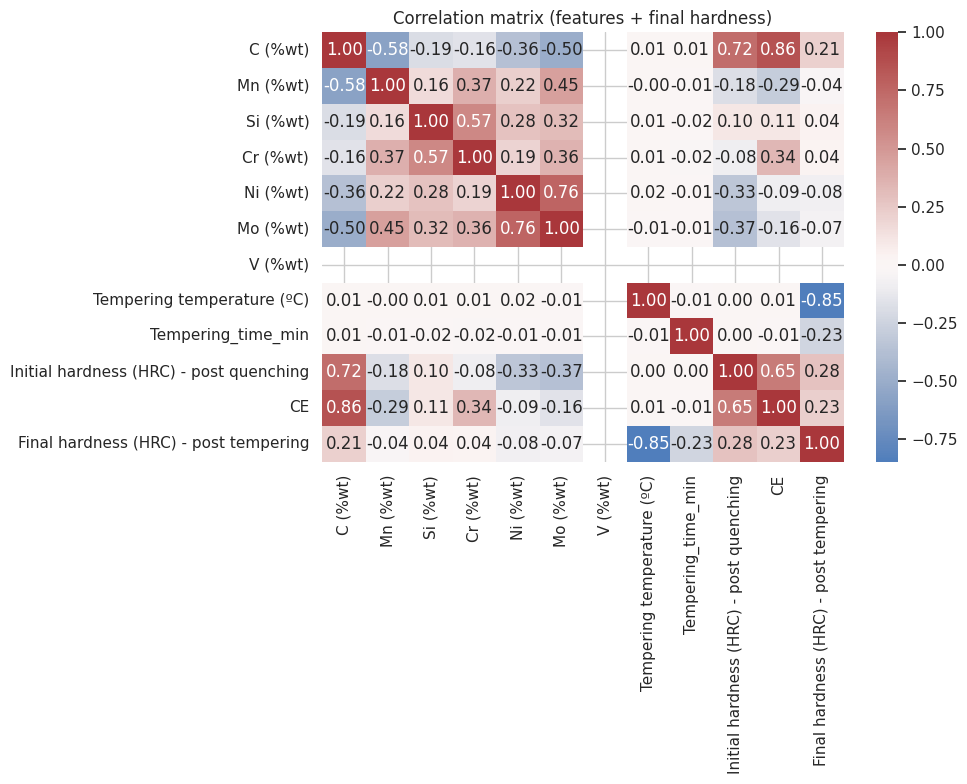

In [ ]:
# 1. Correlation heatmap
plt.figure(figsize=(10,8))
corr = data[features + [target]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix (features + final hardness)')
plt.tight_layout()
plt.show()

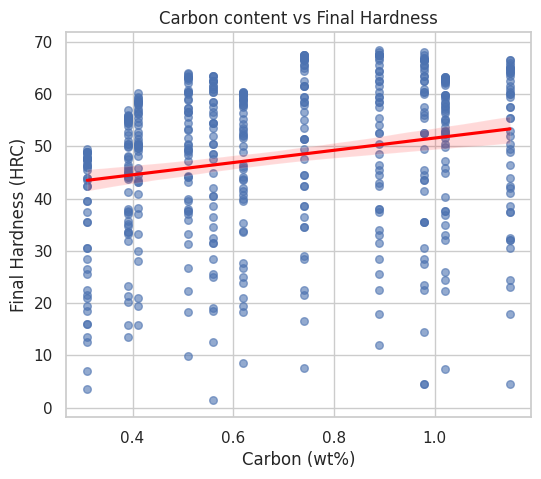

In [ ]:
# %%
# 2. Carbon vs Final Hardness scatter + line
plt.figure(figsize=(6,5))
sns.regplot(x='C (%wt)', y=target, data=data, scatter_kws={'s':30, 'alpha':0.6}, line_kws={'color':'red'})
plt.xlabel('Carbon (wt%)')
plt.ylabel('Final Hardness (HRC)')
plt.title('Carbon content vs Final Hardness')
plt.show()

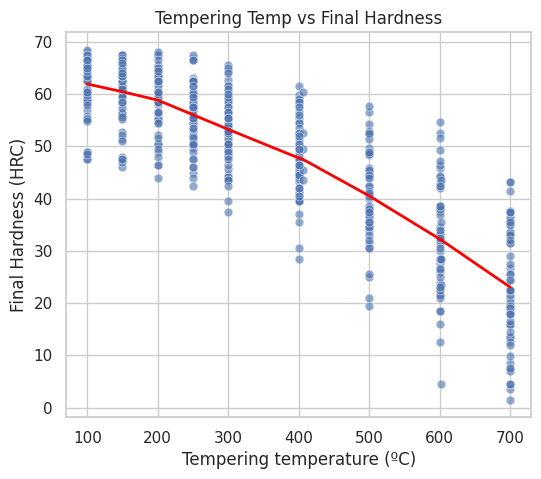

In [ ]:
# 3. Tempering Temperature vs Final Hardness (with LOWESS smooth)
plt.figure(figsize=(6,5))
sns.scatterplot(x='Tempering temperature (ºC)', y=target, data=data, s=40, alpha=0.6)
try:
    import statsmodels.api as sm
    lowess = sm.nonparametric.lowess
    z = lowess(data[target], data['Tempering temperature (ºC)'], frac=0.3)
    plt.plot(z[:,0], z[:,1], color='red', lw=2)
except Exception:
    pass
plt.xlabel('Tempering temperature (ºC)')
plt.ylabel('Final Hardness (HRC)')
plt.title('Tempering Temp vs Final Hardness')
plt.show()


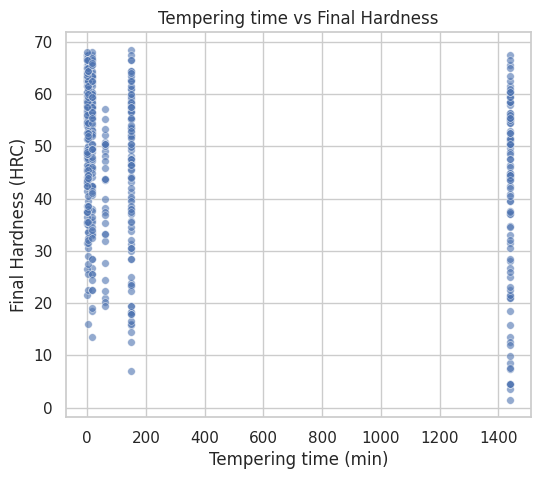

In [ ]:
# 4. Tempering time vs Final Hardness
plt.figure(figsize=(6,5))
sns.scatterplot(x='Tempering_time_min', y=target, data=data, s=30, alpha=0.6)
plt.xlabel('Tempering time (min)')
plt.ylabel('Final Hardness (HRC)')
plt.title('Tempering time vs Final Hardness')
plt.show()

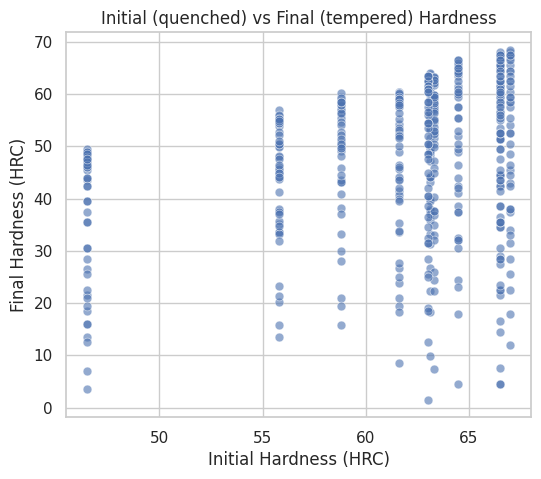

In [ ]:
# 5. Initial vs Final Hardness
if 'Initial hardness (HRC) - post quenching' in features:
    plt.figure(figsize=(6,5))
    sns.scatterplot(x='Initial hardness (HRC) - post quenching', y=target, data=data, s=40, alpha=0.6)
    plt.title('Initial (quenched) vs Final (tempered) Hardness')
    plt.xlabel('Initial Hardness (HRC)')
    plt.ylabel('Final Hardness (HRC)')
    plt.show()


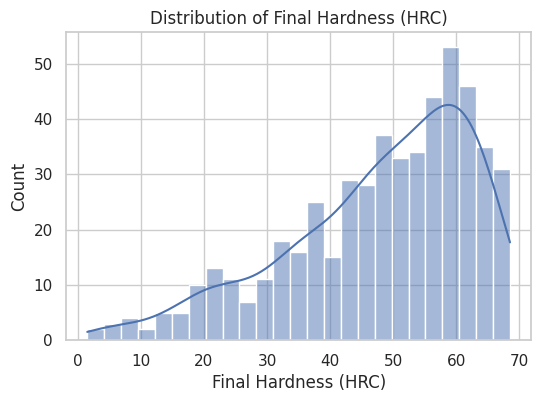

In [ ]:
# %%
# 6. Distribution of Final Hardness
plt.figure(figsize=(6,4))
sns.histplot(data[target], kde=True, bins=25)
plt.title('Distribution of Final Hardness (HRC)')
plt.xlabel('Final Hardness (HRC)')
plt.show()

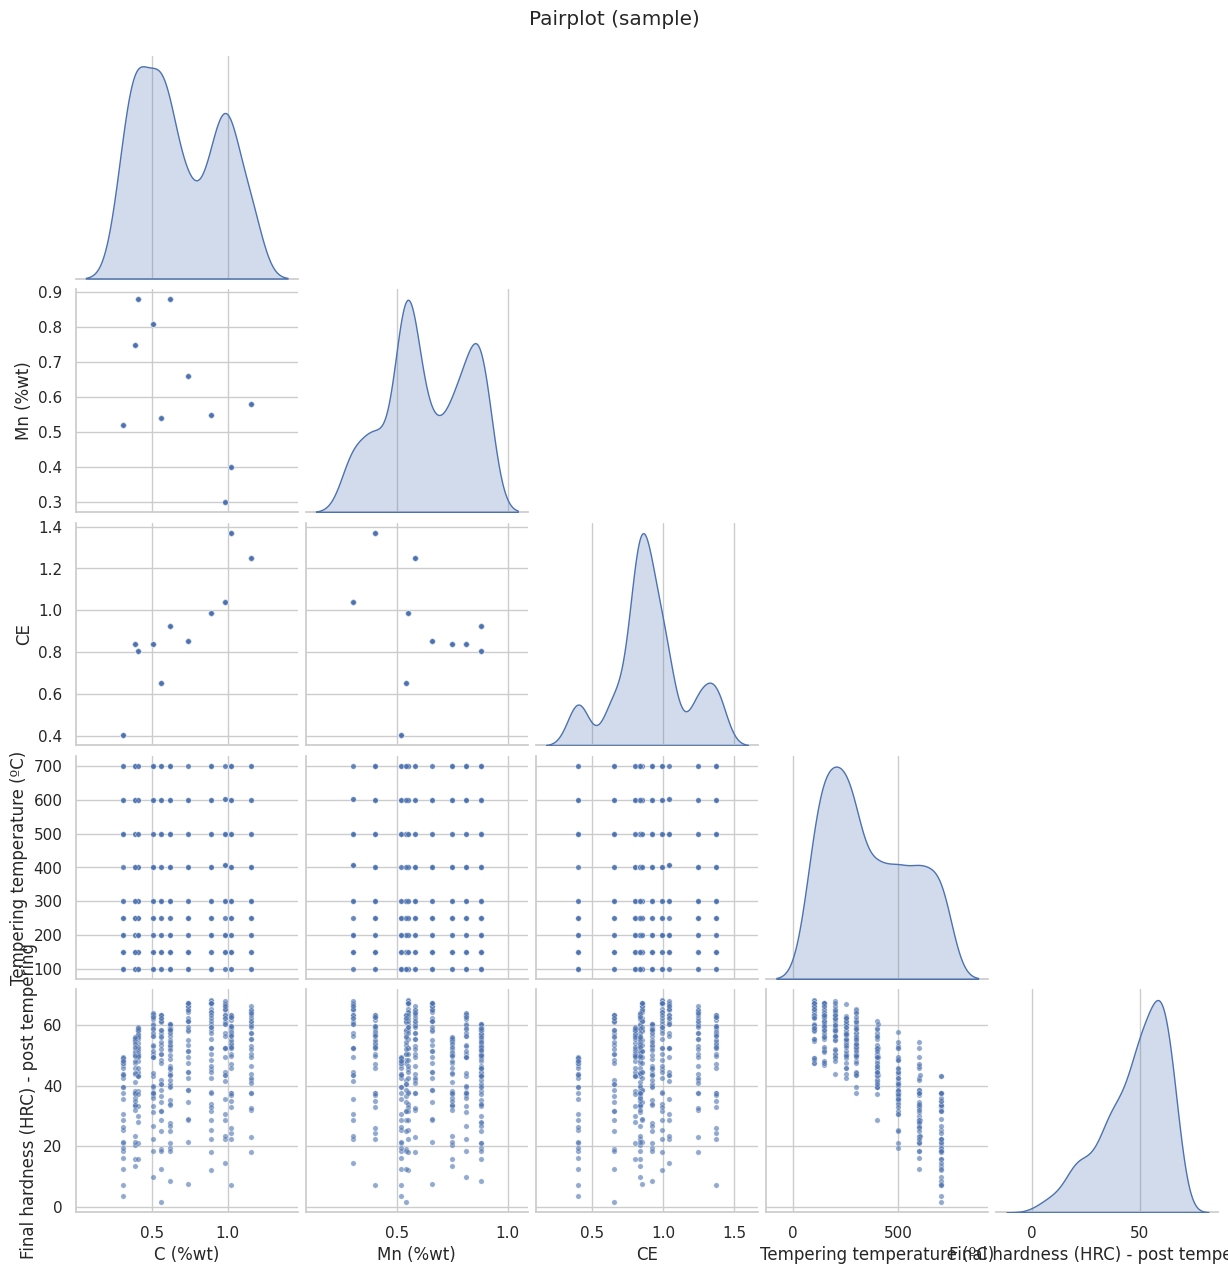

In [ ]:
# 7. Pairplot of key variables (small sample to keep it readable)
pp_cols = [c for c in ['C (%wt)','Mn (%wt)','CE','Tempering temperature (ºC)', target] if c in data.columns]
sns.pairplot(data[pp_cols].sample(min(400, len(data))), corner=True, diag_kind='kde', plot_kws={'s':15, 'alpha':0.6})
plt.suptitle('Pairplot (sample)', y=1.02)
plt.show()

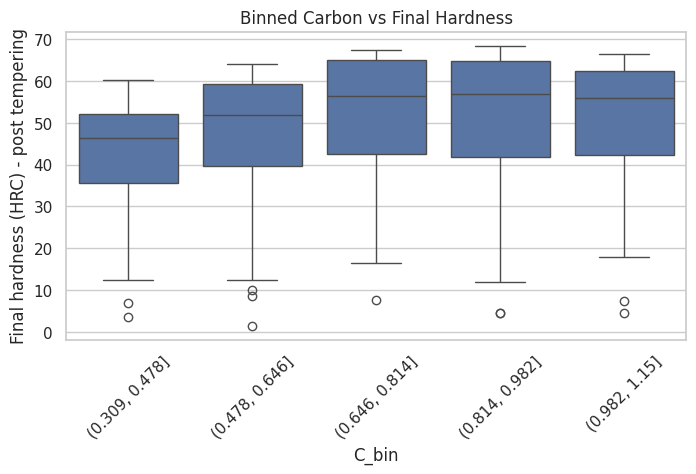

In [ ]:
# 8. Binned boxplots (e.g. carbon binned vs hardness)
data['C_bin'] = pd.cut(data['C (%wt)'], bins=5)
plt.figure(figsize=(8,4))
sns.boxplot(x='C_bin', y=target, data=data)
plt.xticks(rotation=45)
plt.title('Binned Carbon vs Final Hardness')
plt.show()

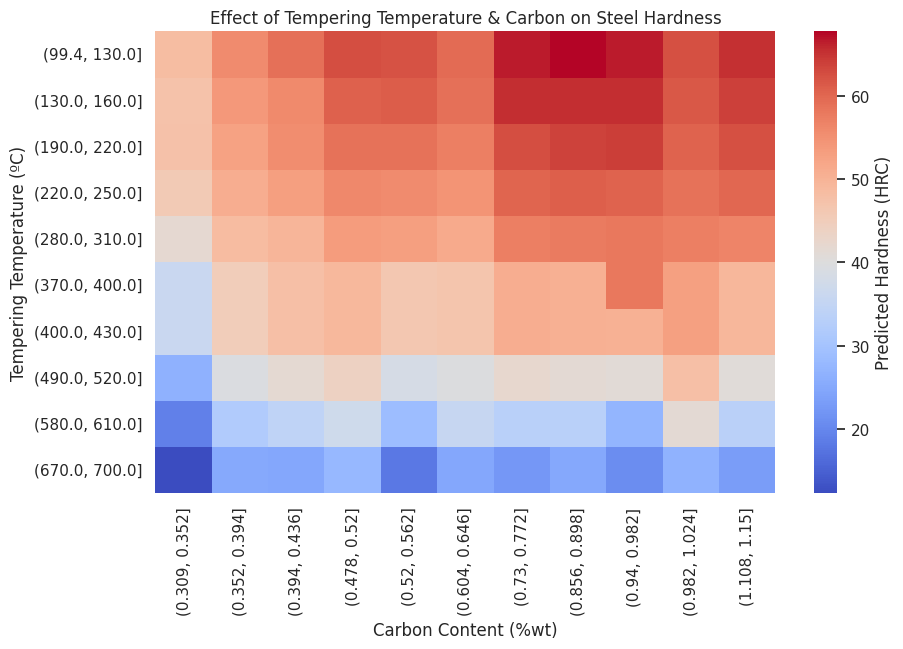

In [ ]:
# 9. 2D contour/map: Tempering Temperature vs Carbon -> Predicted Hardness

# Create bins for temperature and carbon
temp_bins = pd.cut(data['Tempering temperature (ºC)'], bins=20)
carbon_bins = pd.cut(data['C (%wt)'], bins=20)

# Create pivot table safely
grid = data.pivot_table(values=target, index=temp_bins, columns=carbon_bins, aggfunc='mean')

# Clean up NaN values
grid = grid.fillna(method='ffill').fillna(method='bfill')

# Plot heatmap of strength based on carbon and temperature
plt.figure(figsize=(10, 6))
sns.heatmap(grid, cmap='coolwarm', cbar_kws={'label': 'Predicted Hardness (HRC)'})
plt.title("Effect of Tempering Temperature & Carbon on Steel Hardness")
plt.xlabel("Carbon Content (%wt)")
plt.ylabel("Tempering Temperature (ºC)")
plt.show()


In [ ]:

# Prepare X, y arrays
X = data[features].values
y = data[target].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=RND)
print("Train/Test sizes:", X_train.shape, X_test.shape)

# scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "scaler_hardness.pkl")

Train/Test sizes: (423, 11) (94, 11)


['scaler_hardness.pkl']

In [ ]:
# %%
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression performance:")
metrics_lr = print_metrics(y_test, y_pred_lr)


Linear Regression performance:
R2 = 0.8466 | MAE = 4.305 | RMSE = 5.657


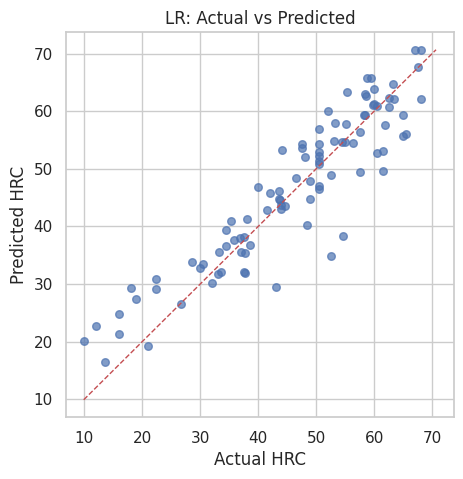

In [ ]:
# plot actual vs pred
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_lr, s=30, alpha=0.7)
mn, mx = min(y_test.min(), y_pred_lr.min()), max(y_test.max(), y_pred_lr.max())
plt.plot([mn,mx],[mn,mx], 'r--', lw=1)
plt.xlabel('Actual HRC'); plt.ylabel('Predicted HRC'); plt.title('LR: Actual vs Predicted')
plt.show()

In [ ]:
# %% [markdown]
# ### 6.2 Random Forest

# %%
rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=RND, n_jobs=-1)
rf.fit(X_train, y_train)  # using unscaled X for tree
y_pred_rf = rf.predict(X_test)
print("Random Forest performance:")
metrics_rf = print_metrics(y_test, y_pred_rf)


Random Forest performance:
R2 = 0.9731 | MAE = 1.707 | RMSE = 2.370


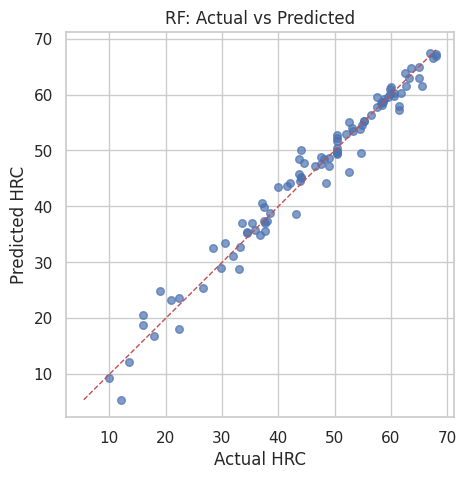

In [ ]:
# plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_rf, s=30, alpha=0.7)
mn, mx = min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max())
plt.plot([mn,mx],[mn,mx], 'r--', lw=1)
plt.xlabel('Actual HRC'); plt.ylabel('Predicted HRC'); plt.title('RF: Actual vs Predicted')
plt.show()

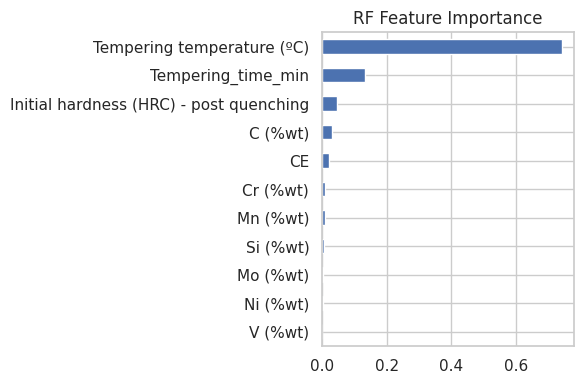

In [ ]:
# feature importance
fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(6,4))
fi.plot(kind='barh'); plt.title('RF Feature Importance'); plt.tight_layout(); plt.show()


In [ ]:
!pip install --upgrade xgboost
import xgboost as xgb


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.05,
    'eval_metric': 'rmse',
    'seed': RND
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=25
)

y_pred_xgb = xgb_model.predict(dtest)


[0]	train-rmse:14.15448	eval-rmse:13.96329
[1]	train-rmse:13.52759	eval-rmse:13.34641
[2]	train-rmse:12.93188	eval-rmse:12.76555
[3]	train-rmse:12.36538	eval-rmse:12.20955
[4]	train-rmse:11.82429	eval-rmse:11.68940
[5]	train-rmse:11.31259	eval-rmse:11.18744
[6]	train-rmse:10.81974	eval-rmse:10.70620
[7]	train-rmse:10.35408	eval-rmse:10.25862
[8]	train-rmse:9.91016	eval-rmse:9.81712
[9]	train-rmse:9.48793	eval-rmse:9.41063
[10]	train-rmse:9.08652	eval-rmse:9.03672
[11]	train-rmse:8.70130	eval-rmse:8.65950
[12]	train-rmse:8.33358	eval-rmse:8.30076
[13]	train-rmse:7.98730	eval-rmse:7.96910
[14]	train-rmse:7.65307	eval-rmse:7.66028
[15]	train-rmse:7.33253	eval-rmse:7.36335
[16]	train-rmse:7.02750	eval-rmse:7.07332
[17]	train-rmse:6.73991	eval-rmse:6.80197
[18]	train-rmse:6.46384	eval-rmse:6.54447
[19]	train-rmse:6.19840	eval-rmse:6.29543
[20]	train-rmse:5.94750	eval-rmse:6.06310
[21]	train-rmse:5.70793	eval-rmse:5.84887
[22]	train-rmse:5.47805	eval-rmse:5.63521
[23]	train-rmse:5.26074	eval

In [ ]:
# Ensure X_train is a DataFrame (not numpy)
#X_train = pd.DataFrame(X_train, columns=feature_cols)
#X_test = pd.DataFrame(X_test, columns=feature_cols)

In [ ]:
# ### 6.4 ANN (Keras) — a compact MLP
# We'll train a small network on scaled features.

# %%
def build_ann(input_dim, units=[128,64], lr=1e-3, dropout=0.15):
    inp = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)
    for u in units:
        x = layers.Dense(u, activation='relu')(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])
    return model

ann = build_ann(X_train_scaled.shape[1], units=[128,64], lr=1e-3, dropout=0.12)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = ann.fit(X_train_scaled, y_train, validation_split=0.12, epochs=300, batch_size=32, callbacks=[es], verbose=0)

# predict
y_pred_ann = ann.predict(X_test_scaled).ravel()
print("ANN performance:")
metrics_ann = print_metrics(y_test, y_pred_ann)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
ANN performance:
R2 = 0.8819 | MAE = 3.491 | RMSE = 4.965


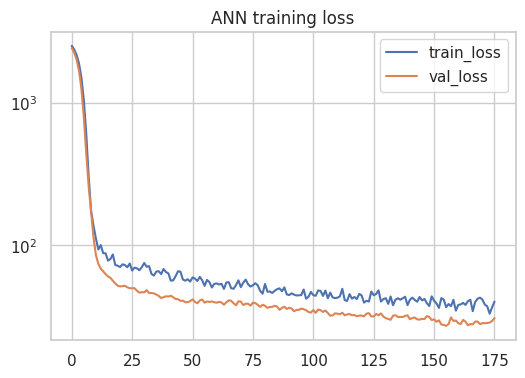

In [ ]:
# training curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend(); plt.title('ANN training loss'); plt.show()




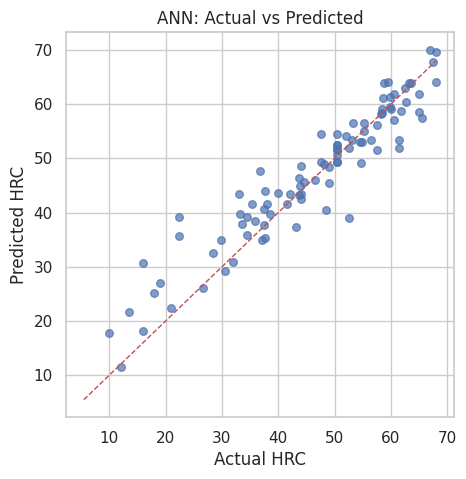

In [ ]:
# plot actual vs pred
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_ann, s=30, alpha=0.7)
plt.plot([mn,mx],[mn,mx], 'r--', lw=1)
plt.xlabel('Actual HRC'); plt.ylabel('Predicted HRC'); plt.title('ANN: Actual vs Predicted')
plt.show()

In [ ]:
results = pd.DataFrame({
    'model': ['LinearRegression','RandomForest','ANN'],
    'r2':[metrics_lr['r2'], metrics_rf['r2'], metrics_ann['r2']],
    'mae':[metrics_lr['mae'], metrics_rf['mae'], metrics_ann['mae']],
    'rmse':[metrics_lr['rmse'], metrics_rf['rmse'], metrics_ann['rmse']]
})


In [ ]:
results = pd.DataFrame(results)
display(results)


,model,r2,mae,rmse
0,LinearRegression,0.846576,4.305349,5.657319
1,RandomForest,0.973070,1.706532,2.370185
2,ANN,0.881853,3.490788,4.964511


SHAP summary (RF)


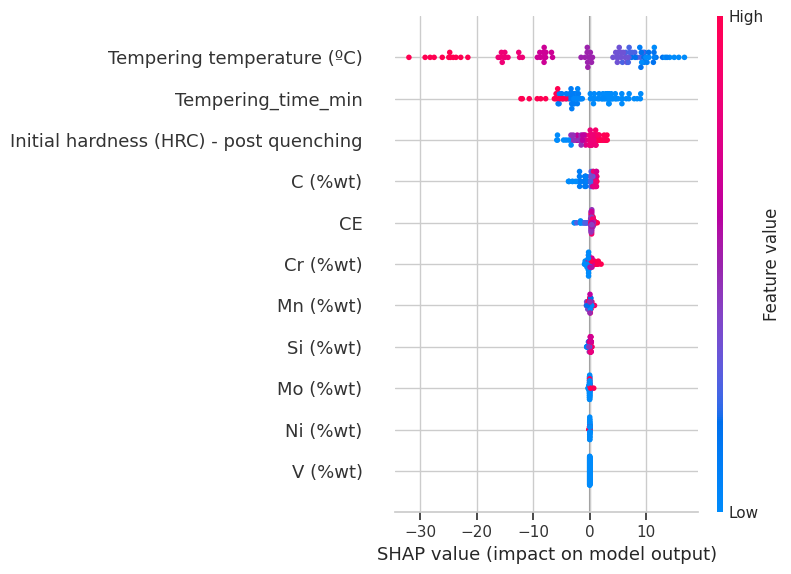

Top feature: Tempering temperature (ºC)


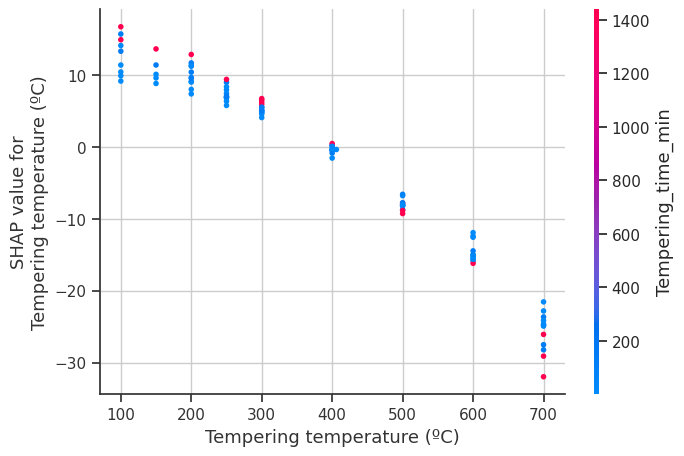

ValueError: could not convert string to float: '[4.8332623E1]'

In [ ]:
# ## 8 — Explainability: SHAP & feature importance
# We will use TreeExplainer for tree models (fast) and KernelExplainer for ANN if needed (slow).

# %%
# SHAP for Random Forest (TreeExplainer)
explainer_rf = shap.TreeExplainer(rf)
# Use a sample to speed up
X_test_df = pd.DataFrame(X_test, columns=features)
shap_values_rf = explainer_rf.shap_values(X_test_df)
print("SHAP summary (RF)")
shap.summary_plot(shap_values_rf, X_test_df, feature_names=features, show=True)

# SHAP dependence plot for top feature
top_feat = list(pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).index[:1])[0]
print("Top feature:", top_feat)
shap.dependence_plot(top_feat, shap_values_rf, X_test_df, show=True)

# Optional: SHAP for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_df)
shap.summary_plot(shap_values_xgb, X_test_df, feature_names=features, show=True)

In [ ]:
from scipy.optimize import minimize

def predict_from_features_row(feat_row, model_choice='rf'):
    # feat_row = dict feature_name->value; expects full features
    Xr = pd.DataFrame([feat_row])[features].values
    if model_choice == 'rf':
        return float(rf.predict(Xr))
    elif model_choice == 'xgb':
        return float(xgb_model.predict(Xr))
    elif model_choice == 'ann':
        return float(ann.predict(scaler.transform(Xr))[0,0])
    else:
        # linear
        return float(lr.predict(scaler.transform(Xr))[0])

def recommend_tempering_temp(composition_dict, desired_hardness, time_min=None, search_range=(150,600), step=2, model_choice='rf'):
    temps = np.arange(search_range[0], search_range[1]+1, step)
    preds = []
    for T in temps:
        row = {}
        # fill composition and defaults
        for f in features:
            if f in composition_dict:
                row[f] = composition_dict[f]
            else:
                # if tempering related fields
                if f=='Tempering temperature (ºC)':
                    row[f] = T
                elif f=='Tempering_time_min':
                    row[f] = time_min if time_min is not None else np.median(data['Tempering_time_min'].dropna()) if 'Tempering_time_min' in data.columns else 60
                elif f=='Initial hardness (HRC) - post quenching':
                    row[f] = composition_dict.get(f, np.median(data['Initial hardness (HRC) - post quenching'].dropna())) if 'Initial hardness (HRC) - post quenching' in data.columns else np.mean(data[target])
                else:
                    # fallback numeric default
                    # find median from data if available
                    if f in data.columns:
                        row[f] = float(data[f].median())
                    else:
                        row[f] = 0.0
        # ensure CE is recalculated if part of features
        if 'CE' in features:
            # use our CE calc
            row['CE'] = row.get('C (%wt)',0.0) + row.get('Mn (%wt)',0.0)/6 + (row.get('Cr (%wt)',0.0)+row.get('Mo (%wt)',0.0)+row.get('V (%wt)',0.0))/5 + (row.get('Ni (%wt)',0.0)+row.get('Cu (%wt)',0.0))/15
        preds.append(predict_from_features_row(row, model_choice=model_choice))
    preds = np.array(preds)
    idx = (np.abs(preds - desired_hardness)).argmin()
    best_temp = temps[idx]
    return {'temps':temps, 'preds':preds, 'best_temp':int(best_temp), 'pred_at_best':float(preds[idx])}


In [ ]:
# Example usage: provide composition values mapping to feature names
# For example:
example_comp = {
    'C (%wt)': 0.45, 'Mn (%wt)': 0.9, 'Si (%wt)': 0.25,
    'Cr (%wt)': 0.2, 'Ni (%wt)': 0.0, 'Mo (%wt)': 0.0, 'V (%wt)': 0.0,
    # optional: 'Initial hardness (HRC) - post quenching': 50
}
desired = float(input("Enter target hardness (HRC) to recommend tempering temperature") or 45)
print("Computing recommendation (this may take a few seconds)...")
rec = recommend_tempering_temp(example_comp, desired_hardness=desired, search_range=(150,600), step=2, model_choice='rf')


Enter target hardness (HRC) to recommend tempering temperature
Computing recommendation (this may take a few seconds)...


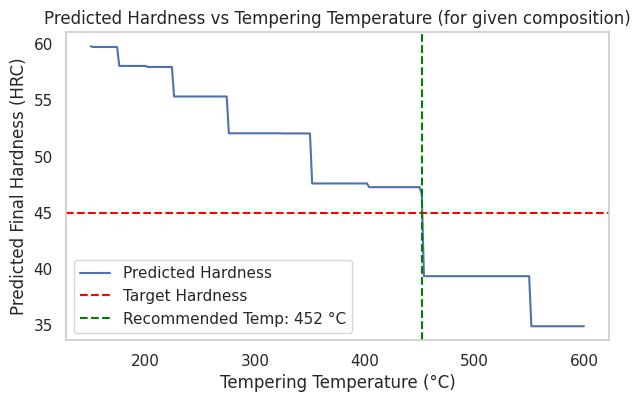

Recommended tempering temperature: 452 °C (predicted hardness 46.68 HRC)


In [ ]:
# Plot predicted hardness vs temp
plt.figure(figsize=(7,4))
plt.plot(rec['temps'], rec['preds'], '-b', label='Predicted Hardness')
plt.axhline(desired, color='red', linestyle='--', label='Target Hardness')
plt.axvline(rec['best_temp'], color='green', linestyle='--', label=f"Recommended Temp: {rec['best_temp']} °C")
plt.xlabel('Tempering Temperature (°C)')
plt.ylabel('Predicted Final Hardness (HRC)')
plt.title('Predicted Hardness vs Tempering Temperature (for given composition)')
plt.legend()
plt.grid()
plt.show()

print(f"Recommended tempering temperature: {rec['best_temp']} °C (predicted hardness {rec['pred_at_best']:.2f} HRC)")

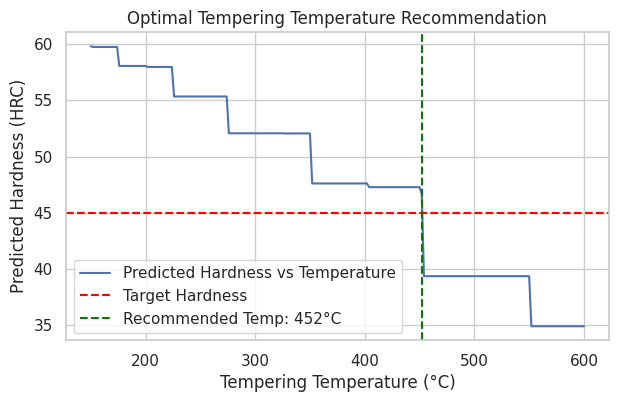

In [ ]:
# ✅ 10. Plot Prediction vs Temperature
plt.figure(figsize=(7,4))
plt.plot(rec['temps'], rec['preds'], label='Predicted Hardness vs Temperature')
plt.axhline(desired, linestyle='--', label='Target Hardness', color='red')
plt.axvline(rec['best_temp'], linestyle='--', label=f"Recommended Temp: {rec['best_temp']}°C", color='green')
plt.xlabel("Tempering Temperature (°C)")
plt.ylabel("Predicted Hardness (HRC)")
plt.title("Optimal Tempering Temperature Recommendation")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# %%
os.makedirs('figures', exist_ok=True)


In [ ]:
# Save example plots (already displayed) - we will save a few core figures programmatically
plt.figure(figsize=(6,4))
sns.histplot(data[target], kde=True, bins=25)
plt.title('Distribution of Final Hardness (HRC)')
plt.savefig('figures/hardness_distribution.png', dpi=200)
plt.close()

In [ ]:
# Save feature importance (RF)
fi.plot(kind='barh', figsize=(6,4), title='RF Feature Importance')
plt.tight_layout()
plt.savefig('figures/feature_importance_rf.png', dpi=200)
plt.close()


In [ ]:
# 1. Install XGBoost if not available
!pip install xgboost

from xgboost import XGBRegressor

# 2. Train XGBoost
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# 3. Predictions & Metrics
y_pred_xgb = xgb_model.predict(X_test)
metrics_xgb = {
    'r2': r2_score(y_test, y_pred_xgb),
    'mae': mean_absolute_error(y_test, y_pred_xgb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_xgb))
}
print("XGBoost Performance:", metrics_xgb)

# 4. Compare all models again
results = {
    'linear_regression': metrics_lr,
    'random_forest': metrics_rf,
    'xgboost': metrics_xgb,
    'ann': metrics_ann
}

best_model_name = max(results, key=lambda x: results[x]['r2'])
print("Best Model is:", best_model_name)


XGBoost Performance: {'r2': 0.987079717549621, 'mae': 1.1745513297141867, 'rmse': np.float64(1.6417245464890649)}
Best Model is: xgboost


In [ ]:
#  Safe dictionary creation to avoid NameError for missing models
results = {
    'linear_regression': metrics_lr if 'metrics_lr' in locals() else 'Not executed',
    'random_forest': metrics_rf if 'metrics_rf' in locals() else 'Not executed',
    'xgboost': metrics_xgb if 'metrics_xgb' in locals() else 'Not executed',
    'ann': metrics_ann if 'metrics_ann' in locals() else 'Not executed',
    'best_model': best_model_name if 'best_model_name' in locals() else 'Not Available'
}

results


{'linear_regression': {'r2': 0.8465761798936422,
  'mae': 4.305348970783526,
  'rmse': np.float64(5.657319204440347)},
 'random_forest': {'r2': 0.9730700161600356,
  'mae': 1.706531914893625,
  'rmse': np.float64(2.3701854846569557)},
 'xgboost': {'r2': 0.987079717549621,
  'mae': 1.1745513297141867,
  'rmse': np.float64(1.6417245464890649)},
 'ann': {'r2': 0.8818525573586314,
  'mae': 3.4907882304901783,
  'rmse': np.float64(4.964510693439919)},
 'best_model': 'xgboost'}

In [ ]:
# Compare all available models
results = pd.DataFrame({
    'Linear Regression': metrics_lr if 'metrics_lr' in locals() else None,
    'Random Forest': metrics_rf if 'metrics_rf' in locals() else None,
    'XGBoost': metrics_xgb if 'metrics_xgb' in locals() else None,
    'ANN': metrics_ann if 'metrics_ann' in locals() else None
}).T

results


,r2,mae,rmse
Linear Regression,0.846576,4.305349,5.657319
Random Forest,0.973070,1.706532,2.370185
XGBoost,0.987080,1.174551,1.641725
ANN,0.881853,3.490788,4.964511


In [ ]:
# This will show which variables exist in memory
[x for x in locals().keys() if 'rf' in x.lower() or 'forest' in x.lower()]


['RandomForestRegressor',
 'rf',
 'y_pred_rf',
 'metrics_rf',
 'explainer_rf',
 'shap_values_rf']

In [ ]:
import joblib

# Save ML models with correct variable names
joblib.dump(rf, 'random_forest_hardness_model.pkl')  # Change rf to your variable
joblib.dump(lr, 'linear_regression_model.pkl')
joblib.dump(xgb_model, 'xgboost_hardness_model.pkl')

# Save ANN properly
ann.save('ann_hardness_model.keras')  # or .h5

print("All models saved successfully!")


All models saved successfully!
